<a href="https://colab.research.google.com/github/AmbiTyga/Bio-VI-BERT/blob/main/Baselines-Multi-label-Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git -q
!pip install pytorch-lightning -q
!git clone https://github.com/1Konny/gradcam_plus_plus-pytorch
!cp /content/gradcam_plus_plus-pytorch/*.py ./

     |████████████████████████████████| 849kB 7.0MB/s 
     |████████████████████████████████| 184kB 51.2MB/s 
     |████████████████████████████████| 829kB 53.9MB/s 
     |████████████████████████████████| 112kB 52.6MB/s 
     |████████████████████████████████| 276kB 55.2MB/s 
     |████████████████████████████████| 1.3MB 52.6MB/s 
     |████████████████████████████████| 143kB 53.7MB/s 
     |████████████████████████████████| 296kB 53.0MB/s 
Cloning into 'gradcam_plus_plus-pytorch'...
remote: Enumerating objects: 79, done.
remote: Total 79 (delta 0), reused 0 (delta 0), pack-reused 79
Unpacking objects: 100% (79/79), done.


In [2]:
!wget https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Train.7z
!7z x /content/Train.7z

--2021-04-29 10:59:04--  https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Train.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13524763 (13M) [application/octet-stream]
Saving to: ‘Train.7z’

Train.7z            100%[===================>]  12.90M  41.8MB/s    in 0.3s    

2021-04-29 10:59:05 (41.8 MB/s) - ‘Train.7z’ saved [13524763/13524763]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 13524763 bytes (13 MiB)

Extracting archive: /content/Train.7z
--
Path = /content/Train.7z
Ty

In [3]:
!wget https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Val.7z
!7z x /content/Val.7z

--2021-04-29 10:59:06--  https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Val.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4593856 (4.4M) [application/octet-stream]
Saving to: ‘Val.7z’

Val.7z              100%[===================>]   4.38M  --.-KB/s    in 0.1s    

2021-04-29 10:59:07 (38.7 MB/s) - ‘Val.7z’ saved [4593856/4593856]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 4593856 bytes (4487 KiB)

Extracting archive: /content/Val.7z
--
Path = /content/Val.7z
Type = 7z
Phy

In [1]:
import timm
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, sampler
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.model_selection import train_test_split
from glob import glob
from PIL import Image
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from pytorch_lightning.callbacks import ModelCheckpoint

from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2

## Labeling

In [ ]:
from glob import glob
images = [x for x in glob('./val/*/*') if 'val.csv' not in x]
for i in images:
  Image.open(i).convert('RGB').save(i)

In [2]:
train = pd.read_csv('/content/train/train.csv')
val = pd.read_csv('/content/val/val.csv')

In [3]:
le = LabelEncoder()
train['class_label'] = le.fit_transform(train['class'])
val['class_label'] = le.transform(val['class'])

In [4]:
train_transformer = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

val_transformer = transforms.Compose([
        transforms.Resize((224,224)),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

In [5]:
class SpeciesDataset(Dataset):
  def __init__(self,csv_file,transform):
    super().__init__()
    csv = csv_file[['class_label','img_path']]
    self.labels = csv['class_label'].values

    self.images = csv['img_path'].values
    self.transform = transform

    # self.LE = LabelEncoder()
    # self.labels = self.LE.fit_transform(labels)    

  def __len__(self):
    # return size of dataset
    return len(self.images)

  def __getitem__(self, index):
    img = Image.open(self.images[index])
    img = self.transform(img)

    label = self.labels[index]

    return {'images':img, 'labels':label}

In [6]:

class_counts = train['class_label'].value_counts().to_dict()
train_weights = torch.tensor([1/class_counts[label] for label in train['class_label'].values])

train_dataset = SpeciesDataset(train,transform=train_transformer)

class_counts = val['class_label'].value_counts().to_dict()
val_weights = torch.tensor([1/class_counts[label] for label in val['class_label'].values])

val_dataset = SpeciesDataset(val,transform=val_transformer)

In [7]:
class ResNet200d(pl.LightningModule):
  def __init__(
      self,
      num_classes_classifier,
      train_weights,
      val_weights,
      train_dataset,
      val_dataset):
    super().__init__()

    self.tw = train_weights
    self.vw = val_weights

    self.train_dataset = train_dataset
    self.val_dataset = val_dataset

    self.loss_fn = nn.CrossEntropyLoss()

    self.img_transformer = timm.models.resnet200d(pretrained=True,num_classes = num_classes_classifier)
    
  def forward(self,img):  
    return self.img_transformer(img)

  def train_dataloader(self):
    return torch.utils.data.DataLoader(
        self.train_dataset,
        batch_size=32,
        sampler=torch.utils.data.WeightedRandomSampler(self.tw,num_samples=3360),
        num_workers = os.cpu_count()
        )

  def val_dataloader(self):
    return torch.utils.data.DataLoader(
        self.val_dataset,
        batch_size = 51,
        sampler = torch.utils.data.WeightedRandomSampler(self.vw,num_samples=1155),
        num_workers = os.cpu_count()
        )
    
  def training_step(self, batch ,batch_idx):
    images = batch["images"]
    labels = batch['labels']
    outputs = self(img=images)
    loss = self.loss_fn(outputs,labels)
    acc = (outputs.argmax(dim=1).view(labels.size()).data == labels.data).sum()/labels.size(0)
    
    # self.log("loss",loss,prog_bar=True)
    self.log("accuracy",acc,prog_bar=True)
    return {"loss": loss,'accuracy':acc}

  def validation_step(self, batch ,batch_idx):
    images = batch["images"]
    labels = batch['labels']
    outputs = self(img=images)
    loss = self.loss_fn(outputs,labels)
    acc = (outputs.argmax(dim=1).view(labels.size()).data == labels.data).sum()/labels.size(0)
    
    return {"val_loss": loss.item(),'val_accuracy':acc.item()}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.tensor(
            [output["val_loss"] 
            for output in outputs]
            ).mean()
    avg_acc = torch.tensor(
            [output["val_accuracy"] 
            for output in outputs]
            ).mean()
    
    self.log("val_loss",avg_loss,prog_bar=True)
    self.log("val_accuracy",avg_acc,prog_bar=True)

  def configure_optimizers(self):
    optimizer = [torch.optim.AdamW(
            self.parameters(), 
            lr=1e-4
        )]
    return optimizer

In [8]:
model = ResNet200d(
    num_classes_classifier=7,
    train_weights=train_weights,
    val_weights=val_weights,
    train_dataset=train_dataset,
    val_dataset=val_dataset
    )

In [9]:
early_stop_callback = EarlyStopping(
   monitor='val_accuracy',
   min_delta=0.00,
   patience=20,
   verbose=False,
   mode='max'
)

model_ckpt = ModelCheckpoint(
    monitor='val_accuracy',
    dirpath='./',
    filename='resnet-{val_loss:.2f}-{val_accuracy:.2f}',
    mode='max')

trainer = pl.Trainer(gpus=1,max_epochs=120,accumulate_grad_batches=4,num_sanity_val_steps=2,callbacks=[early_stop_callback,model_ckpt])
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params
-----------------------------------------------------
0 | loss_fn         | CrossEntropyLoss | 0     
1 | img_transformer | ResNet           | 62.7 M
-----------------------------------------------------
62.7 M    Trainable params
0         Non-trainable params
62.7 M    Total params
250.634   Total estimated model params size (MB)


1

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

val_dataset = SpeciesDataset(val,transform=val_transformer)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=51)

model = ResNet200d.load_from_checkpoint("/content/resnet-val-loss=0.00-val_accuracy=0.83.ckpt",num_classes_classifier=7,
    train_weights=None,
    val_weights=None,
    train_dataset=None,
    val_dataset=None
    )
model.cuda()
model.eval()
preds = np.array([])
label = np.array([])
with torch.no_grad():
  for batch in val_loader:
    images = batch["images"].cuda()
    labels = batch['labels']
    label = np.append(label,labels)
    prediction = model(images)
    preds = np.append(preds,prediction.argmax(dim=1).view(labels.size()).cpu().numpy())


print(classification_report(label,preds,target_names=le.classes_))

               precision    recall  f1-score   support

 Aconoidasida       0.99      0.99      0.99       165
      Cestoda       0.85      0.46      0.60        50
  Chromadorea       0.73      0.88      0.80        95
  Conoidasida       0.88      0.93      0.90        80
      Enoplea       0.71      0.80      0.75        25
    Tubulinea       0.86      0.91      0.89        35
Zooflagellate       0.93      0.77      0.84        35

     accuracy                           0.87       485
    macro avg       0.85      0.82      0.83       485
 weighted avg       0.88      0.87      0.87       485



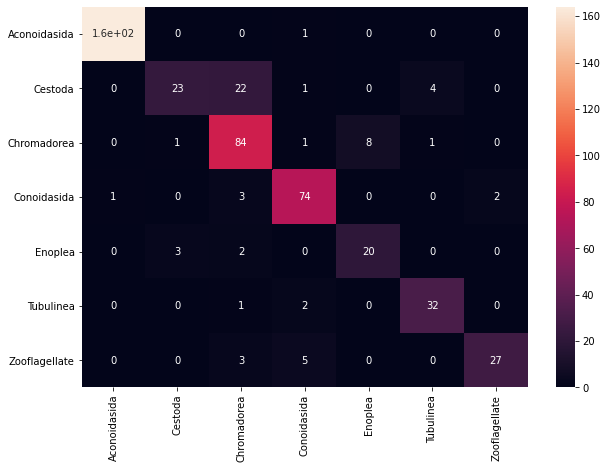

In [12]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
confusion = confusion_matrix(label,preds)
df_cm = pd.DataFrame(confusion, index = le.classes_,
                  columns = le.classes_)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

In [ ]:
!unzip /content/ResNet200D.zip

In [15]:
from utils import visualize_cam, Normalize
from gradcam import GradCAM, GradCAMpp
resnet_model_dict = dict(type='resnet', arch=model.img_transformer, layer_name='layer4', input_size=(224, 224))
resnet_gradcam = GradCAM(resnet_model_dict, True)
resnet_gradcampp = GradCAMpp(resnet_model_dict, True)


saliency_map size : torch.Size([7, 7])
saliency_map size : torch.Size([7, 7])


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [16]:
import torchvision.transforms.functional as F

In [22]:
img = Image.open("/content/ResNet200D/Class/Aconoidasida/Falciparium/Pf_gametocyte_thinF_0_232.jpg")
img_tensor = val_transformer(img).unsqueeze(0).cuda()
torch_img = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor()
                                ])(img)

In [23]:
mask_pp, _ = resnet_gradcampp(img_tensor,class_idx = 0)
heatmap_pp, result_pp = visualize_cam(mask_pp.cpu(), torch_img)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


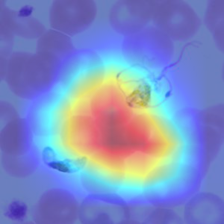

In [42]:
Image.fromarray((result_pp.permute(1,2,0).numpy()*255).astype(np.uint8))

In [44]:
def plot_get(img_path,class_idx,save_path):
  img = Image.open(img_path)
  img_tensor = val_transformer(img).unsqueeze(0).cuda()
  torch_img = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor()
                                ])(img)
  mask_pp, _ = resnet_gradcampp(img_tensor,class_idx = class_idx)
  heatmap_pp, result_pp = visualize_cam(mask_pp.cpu(), torch_img)
  result_img = (result_pp.permute(1,2,0).numpy()*255).astype(np.uint8)
  result_img = Image.fromarray(result_img)
  result_img.save(save_path)
  return result_img

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


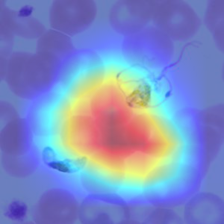

In [45]:
plot_get(
    "/content/ResNet200D/Class/Aconoidasida/Falciparium/Pf_gametocyte_thinF_0_232.jpg",
    0,
    "/content/ResNet200D/Class/Aconoidasida/Falciparium/Aconoidasida=Pf_gametocyte_thinF_0_232.jpg"
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


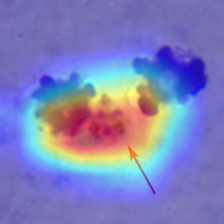

In [46]:
plot_get(
    "/content/ResNet200D/Class/Aconoidasida/Ovale/Po_gametocyte_thickB_0_285.jpg",
    0,
    "/content/ResNet200D/Class/Aconoidasida/Ovale/Aconoidasida=Po_gametocyte_thickB_0_285.jpg"
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


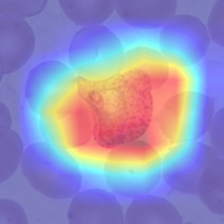

In [47]:
plot_get(
    "/content/ResNet200D/Class/Aconoidasida/Vivax/Pv_troph_thinC_0_312.jpg",
    0,
    "/content/ResNet200D/Class/Aconoidasida/Vivax/Aconoidasida=Pv_troph_thinC_0_312.jpg"
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


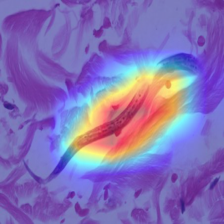

In [48]:
plot_get(
    "/content/ResNet200D/Class/Chromadorea/Stercoralis/S_stercoralis_intbiopsy_400x_BAM1_0_367.jpg",
    2,
    "/content/ResNet200D/Class/Chromadorea/Stercoralis/Chromadorea=S_stercoralis_intbiopsy_400x_BAM1_0_367.jpg"
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


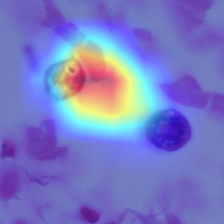

In [49]:
plot_get(
    "/content/ResNet200D/Class/Chromadorea/Stercoralis1K/S_stercoralis_intbiopsy_1000x_BAM1_0_366.jpg",
    2,
    "/content/ResNet200D/Class/Chromadorea/Stercoralis1K/Chromadorea=S_stercoralis_intbiopsy_1000x_BAM1_0_366.jpg"
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


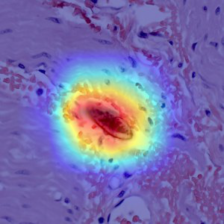

In [50]:
plot_get(
    "/content/ResNet200D/Class/Chromadorea/vermicularis/E_vermicularis_eggs_tissue2_0_157.jpg",
    2,
    "/content/ResNet200D/Class/Chromadorea/vermicularis/Chromadorea=E_vermicularis_eggs_tissue2_0_157.jpg"
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


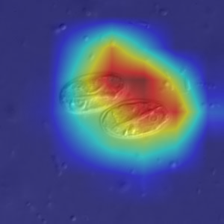

In [51]:
plot_get(
    "/content/ResNet200D/Class/Zooflagellate/Giardia_cyst_dic/Giardia_cyst_dic2_0_165.jpg",
    6,
    "/content/ResNet200D/Class/Zooflagellate/Giardia_cyst_dic/Zooflagellate=Giardia_cyst_dic2_0_165.jpg"
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


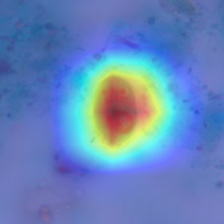

In [52]:
plot_get(
    "/content/ResNet200D/Class/Zooflagellate/Giardia_cyst_tric/Giardia_cyst_tric4_0_174.jpg",
    6,
    "/content/ResNet200D/Class/Zooflagellate/Giardia_cyst_tric/Zooflagellate=Giardia_cyst_tric4_0_174.jpg"
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


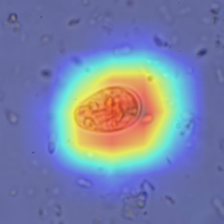

In [53]:
plot_get(
    "/content/ResNet200D/Class/Zooflagellate/Giardia_cyst_wtmt/Giardia_cyst_wtmt4_0_163.jpg",
    6,
    "/content/ResNet200D/Class/Zooflagellate/Giardia_cyst_wtmt/Zooflagellate=Giardia_cyst_wtmt4_0_163.jpg"
)

In [58]:
!zip -rq ResNet200D.zip ResNet200D 

  adding: ResNet200D/ (stored 0%)
  adding: ResNet200D/Phylum/ (stored 0%)
  adding: ResNet200D/Phylum/Sarcomastigophora/ (stored 0%)
  adding: ResNet200D/Phylum/Sarcomastigophora/Giardia troph/ (stored 0%)
  adding: ResNet200D/Phylum/Sarcomastigophora/Giardia troph/Giardia_troph_VT_0_181.jpg (deflated 1%)
  adding: ResNet200D/Phylum/Sarcomastigophora/Giardia cyst/ (stored 0%)
  adding: ResNet200D/Phylum/Sarcomastigophora/Giardia cyst/Giardia_cyst_tric2_3_169.jpg (deflated 2%)
  adding: ResNet200D/Phylum/Sarcomastigophora/Giardia cyst-2/ (stored 0%)
  adding: ResNet200D/Phylum/Sarcomastigophora/Giardia cyst-2/Giardia_cyst_tric10_0_171.jpg (deflated 2%)
  adding: ResNet200D/Phylum/Apicomplexa/ (stored 0%)
  adding: ResNet200D/Phylum/Apicomplexa/Pf_rings_thin/ (stored 0%)
  adding: ResNet200D/Phylum/Apicomplexa/Pf_rings_thin/Pf_rings_thinE_0_213.jpg (deflated 2%)
  adding: ResNet200D/Phylum/Apicomplexa/Sarcocystis/ (stored 0%)
  adding: ResNet200D/Phylum/Apicomplexa/Sarcocystis/Sarcocyst